# Quick-and-easy data science workflow

In this section, we will introduce Student t-tests, FDR-correction, fold-change, and volcano plots.

<a href="https://colab.research.google.com/drive/1quxg4iyYdJ-Jc6kapSG_A-bPZk6bfcOm#scrollTo=lpo2YGMteRcL" target="blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
# Install Python packages
!pip3 install pandas numpy scipy

### Data download

Let's download the feature table file we need to do the analysis. This is a standard output from preprocessing pipelines such as **XCMS**, **MS-DIAL**, and **pcpfm** (***asari***).

*   Feature table - A dataframe with samples in columns and feature intensities in rows.

The dataset consists of six *Escherichia coli* (*E. coli*) samples: three grown with natural-abundance C-12 and three grown with uniformly labeled C-13.

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, mannwhitneyu
import requests, zipfile, io, os

os.makedirs("./Datasets", exist_ok=True)

# Path of feature table on GitHub
datasets = [
    "https://raw.githubusercontent.com/shuzhao-li-lab/khipu/refs/heads/main/testdata/ecoli_pos.tsv",
]

# Download data and put in /Datasets folder
for dataset in datasets:
    r = requests.get(dataset)
    if dataset.endswith(".zip"):
        z = zipfile.ZipFile(io.BytesIO(r.content))
        z.extractall("./Datasets/")
    else:
        with open("./Datasets/" + os.path.basename(dataset), 'bw+') as out_fh:
            out_fh.write(r.content)

# Look at head of table via pd
ecoli = pd.read_table("./Datasets/ecoli_pos.tsv", index_col=0, sep="\t")
ecoli.head()

,mz,rtime,12C_Ecoli_20220321_004,12C_Ecoli_20220321_004_20220322095030,12C_Ecoli_20220321_004_20220322130235,13C_Ecoli_20220321_004,13C_Ecoli_20220321_004_20220322132355,13C_Ecoli_20220321_004_20220322101150
id_number,,,,,,,,
F1,61.9278,40.94,42543,0,0,43369,60144,57714
F2,95.9735,125.06,2079328,984349,1314348,1707804,1299125,1159692
F3,115.9802,11.42,3362695,3228128,4076328,3201740,3942341,3326312
F4,115.9860,5.83,2035714,1739145,1978764,1977817,2040421,1642861
F5,115.9860,27.96,182603,219669,248607,199092,185630,185255


In [62]:
# The first two columns are not useful, so let's drop them
ecoli = ecoli.iloc[:, 2:]
ecoli.head()

,12C_Ecoli_20220321_004,12C_Ecoli_20220321_004_20220322095030,12C_Ecoli_20220321_004_20220322130235,13C_Ecoli_20220321_004,13C_Ecoli_20220321_004_20220322132355,13C_Ecoli_20220321_004_20220322101150
id_number,,,,,,
F1,42543,0,0,43369,60144,57714
F2,2079328,984349,1314348,1707804,1299125,1159692
F3,3362695,3228128,4076328,3201740,3942341,3326312
F4,2035714,1739145,1978764,1977817,2040421,1642861
F5,182603,219669,248607,199092,185630,185255


### Data Normalization

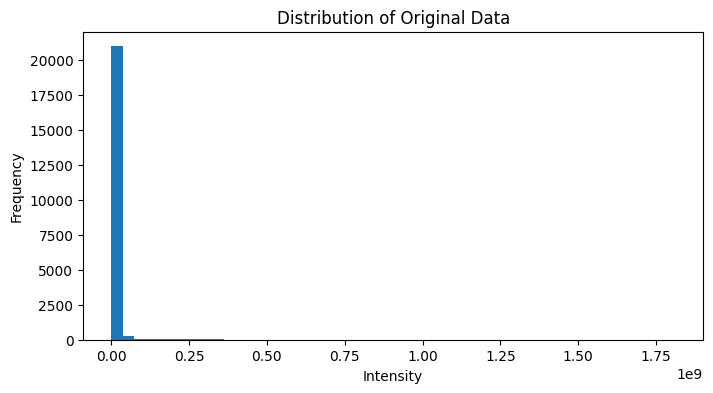

In [63]:
# Plots a histogram of the original data distribution
plt.figure(figsize=(8, 4))
plt.hist(ecoli.values.flatten(), bins=50)
plt.title('Distribution of Original Data')
plt.xlabel('Intensity')
plt.ylabel('Frequency')
plt.show()

Whew, that's a left-skewed distribution - most of our intensities are clustered near zero. To fix this and make the data more normally distributed, let us apply a log2 normalization to the data.

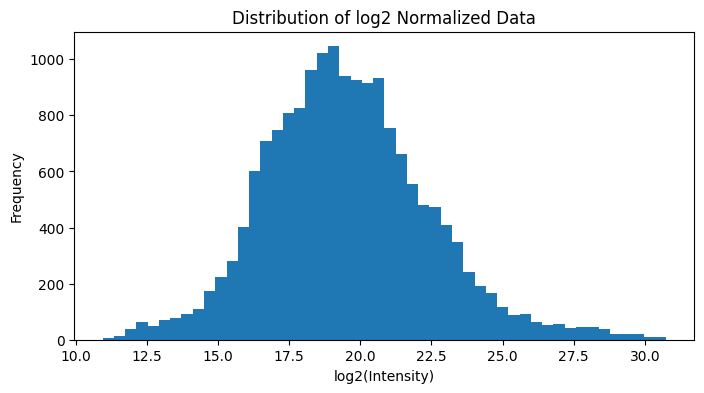

In [64]:
# log2 normalization
# Add a small constant to avoid log(0) if needed, or handle zeros appropriately
ecoli_log2 = np.log2(ecoli.replace(0, np.nan).dropna(how='all', axis=1).dropna(how='all', axis=0))

# Plots a histogram of log2 normalized data distribution
plt.figure(figsize=(8, 4))
plt.hist(ecoli_log2.values.flatten(), bins=50)
plt.title('Distribution of log2 Normalized Data')
plt.xlabel('log2(Intensity)')
plt.ylabel('Frequency')
plt.show()

A lot better! We observe a Gaussian-like distribution centered in the middle of the x-axis, suggesting the log transformation has successfully normalized the data.

## Statistical Analysis

### T-tests

In [65]:
# T-test of each row between 12C and 13C samples
def ttest(row):
    t,p = ttest_ind(row[1:3], row[4:6])
    return p

pvalues_featurelist = ecoli_log2.apply(ttest, axis=1)

In [66]:
# Sort p-values
pvalues_featurelist = pvalues_featurelist.sort_values()
pvalues_featurelist.head(10)

,0
id_number,
F231,0.000004
F1038,0.000035
F2012,0.000061
F1570,0.000069
F1122,0.000093
F413,0.000096
F922,0.000097
F99,0.000118
F172,0.000127


In [67]:
# How many features have p < 0.05
pvalues_featurelist[pvalues_featurelist<0.05].shape

(266,)

In [68]:
from statsmodels.sandbox.stats.multicomp import multipletests

# Drop NaNs, keep track of original indices
valid_idx = pvalues_featurelist.dropna().index
valid_pvals = pvalues_featurelist.loc[valid_idx].values

# Apply Benjamini-Hochberg FDR correction
reject, pvals_corrected, alphacSidak, alphacBonf = multipletests(valid_pvals, method='fdr_bh')

# Create a new Series to hold corrected p-values, align with original indices
corrected_series = pd.Series(data=np.nan, index=pvalues_featurelist.index)
corrected_series.loc[valid_idx] = pvals_corrected

# pvals_corrected now contains the FDR-corrected p-values
# Combine with the original p-values in a DataFrame
pvalues_df = pd.DataFrame({'pvalues': pvalues_featurelist, 'corrected_pvalues': corrected_series})

print(pvalues_df.head())

# How many features have corrected p < 0.05
print("\nNumber of features with a FDR-adjusted p-value < 0.05:", pvalues_df[pvalues_df['corrected_pvalues'] < 0.05].shape[0])

            pvalues  corrected_pvalues
id_number                             
F231       0.000004           0.007667
F1038      0.000035           0.026682
F2012      0.000061           0.026682
F1570      0.000069           0.026682
F1122      0.000093           0.026682

Number of features with a FDR-adjusted p-value < 0.05: 21


### Fold-change

In [69]:
# Calculate fold change for each feature
def fold_change(row):
    mean_12c = row[1:3].mean()
    mean_13c = row[4:6].mean()
    # Add a small constant to avoid division by zero
    if mean_12c == 0 or mean_13c == 0:
      return np.nan
    return mean_13c / mean_12c

fold_changes = ecoli_log2.apply(fold_change, axis=1)

# Print first few fold-change values
print("\nFirst few fold changes:")
print(fold_changes.head())

# How many features have a fold change greater than 1.25 ('upregulated')
print("\nNumber of features with a fold change > 1.25:", fold_changes[fold_changes > 1.25].shape[0])

# How many features have a fold change less than 0.75 ('downregulated')
print("Number of features with a fold change < 0.75:", fold_changes[fold_changes < 0.75].shape[0])


First few fold changes:
id_number
F1         NaN
F2    1.005460
F3    0.999885
F4    0.999090
F5    0.981293
dtype: float64

Number of features with a fold change > 1.25: 129
Number of features with a fold change < 0.75: 28


### Volcano plot

In [71]:
# Perform transformations for the volcano plot
pvalues_df['fold_change'] = fold_changes
pvalues_df['-log10_adj_pval'] = -np.log10(pvalues_df['corrected_pvalues'].replace(0, np.nan))
pvalues_df['log2_fold_change'] = np.log2(pvalues_df['fold_change'].replace(0, np.nan))

print(pvalues_df.head())

            pvalues  corrected_pvalues  -log10_adj_pval  fold_change  \
id_number                                                              
F231       0.000004           0.007667         2.115353     0.777886   
F1038      0.000035           0.026682         1.573777     0.859883   
F2012      0.000061           0.026682         1.573777     0.839331   
F1570      0.000069           0.026682         1.573777     0.814776   
F1122      0.000093           0.026682         1.573777     0.770017   

           log2_fold_change  
id_number                    
F231              -0.362370  
F1038             -0.217788  
F2012             -0.252688  
F1570             -0.295524  
F1122             -0.377038  


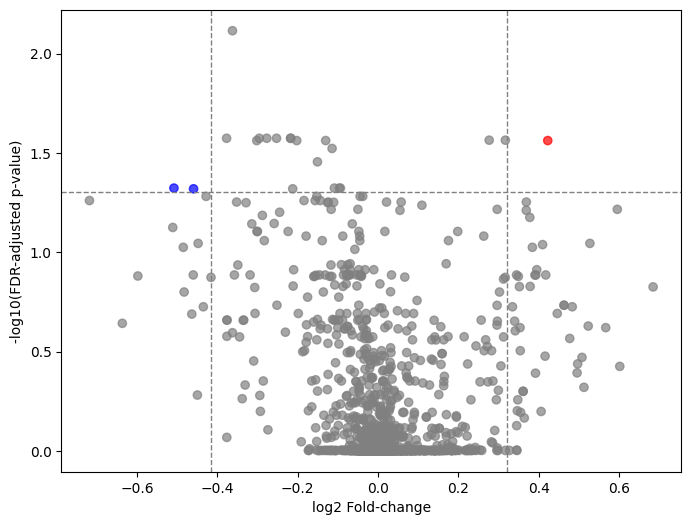

In [72]:
# Define condition for coloring
upregulated = (pvalues_df['corrected_pvalues'] < 0.05) & (pvalues_df['fold_change'] > 1.25)
downregulated = (pvalues_df['corrected_pvalues'] < 0.05) & (pvalues_df['fold_change'] < 0.75)

# Assign colors
colors = np.where(upregulated, 'red',
          np.where(downregulated, 'blue', 'gray'))

# Create plot
plt.figure(figsize=(8,6))
plt.ylabel("-log10(FDR-adjusted p-value)")
plt.xlabel("log2 Fold-change")
plt.scatter(pvalues_df['log2_fold_change'], pvalues_df['-log10_adj_pval'], c=colors, alpha=0.7)

# Add threshold lines
plt.axhline(-np.log10(0.05), color='grey', linestyle='--', linewidth=1)  # p-value cutoff
plt.axvline(np.log2(1.25), color='grey', linestyle='--', linewidth=1)   # positive fold-change cutoff
plt.axvline(np.log2(0.75), color='grey', linestyle='--', linewidth=1)  # negative fold-change cutoff

plt.show()

### Box plot of select feature

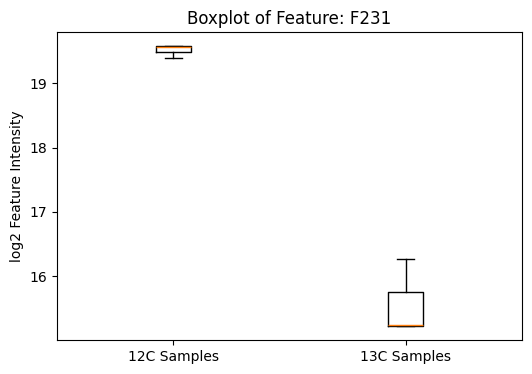

In [73]:
# Select the feature with the lowest corrected p-value (most significant)
most_significant_feature_index = pvalues_df['corrected_pvalues'].idxmin()
feature_to_plot = ecoli_log2.loc[most_significant_feature_index]

# 12C
group12 = feature_to_plot.iloc[0:3]

# 13C
group13 = feature_to_plot.iloc[3:6]

# Put them in a list
data_to_plot = [group12, group13]

plt.figure(figsize=(6, 4))
bp = plt.boxplot(data_to_plot)
plt.xticks([1, 2], ['12C Samples', '13C Samples'])
plt.ylabel('log2 Feature Intensity')
plt.title(f'Boxplot of Feature: {most_significant_feature_index}')
plt.show()
